**TITLE:**
DSCI PROJECT

**INTRO:**

-> background + question 

DSCI100 is a course that introduces students to organization of data through code. Throughout the semester, numerous tools in the R programming language are taught, some of which allow for data to be visualized and others that help data get sorted into much more interpretable forms. To demonstrate these tools and skills gained. Generous peers from the earlier semesters compiled a data frame which we can now use to develop some questions we may have about video games and their audience. The data frame that will be used includes information about the players' experience, subscription to a games related newsletter, hashed email, played hours, name, gender, and age. A research question that may arise from this set of data may be "Can age and hours played predict whether or not that person is subscribed to a game related newsletter?"

-> data description

In order to utilize the data, we can first select the columns of data that are actually relevant to the question which in this case, would be  "Age", "played_hours", and "subscribe". "Age" and "played_hours" act as explanatory variables while "subscribe" will be the response variable. Following the selection of our data, we should change our non numerical data into factors (fct). In the original data set, the column "subscribe" is identified as a string of characters (chr), to change this, the column can be mutated using as_factor() to convert the values into factors (fct). Making this change allows the program to properly identify "subscribe" as a category with a fixed set of groups instead of a set of continuous values. As for "played_hours" and "Age", they can stay as double (dbl) values which are meant for numeric values.

In [33]:
library(tidyverse)
library(repr)
library(tidymodels)

data <- read_csv("https://raw.githubusercontent.com/drsqs257/dsci-project/refs/heads/main/players.csv") |>
    select(subscribe, played_hours, Age) |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(Age != 'NA')
head(data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


Within the data to be used certain information about the data frame can be collected to help familiarize ourselves with the data. Let's take the number of observations/students into account. 

In [4]:
total_number_of_students_in_data <- nrow(data)
total_number_of_students_in_data 

[1] 196

Other pieces of information we can extract include things like the mean hours played across all the participants 

In [84]:
mean_hours <- data |>
    summarise(mean_hours = mean(played_hours))
mean_hours

mean_hours
<dbl>
5.904639


or the mean age.

In [10]:
mean_age <- data |>
    filter(Age != 'NA') |>
    summarise(mean_age = mean(Age))
mean_age

mean_age
<dbl>
20.52062


**METHOD:**

-> data frame:

Thanks to how the data has been selected and mutated, all necessary columns have already been collected and all unnecessary columns are removed. From here, we can create a simple visualization to see how this data looks so far. While making this plot, it should also be noted that the "hours" are log scaled because of the wide-ranging values. Scaling it will make the model more stable and outliers less dominating.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


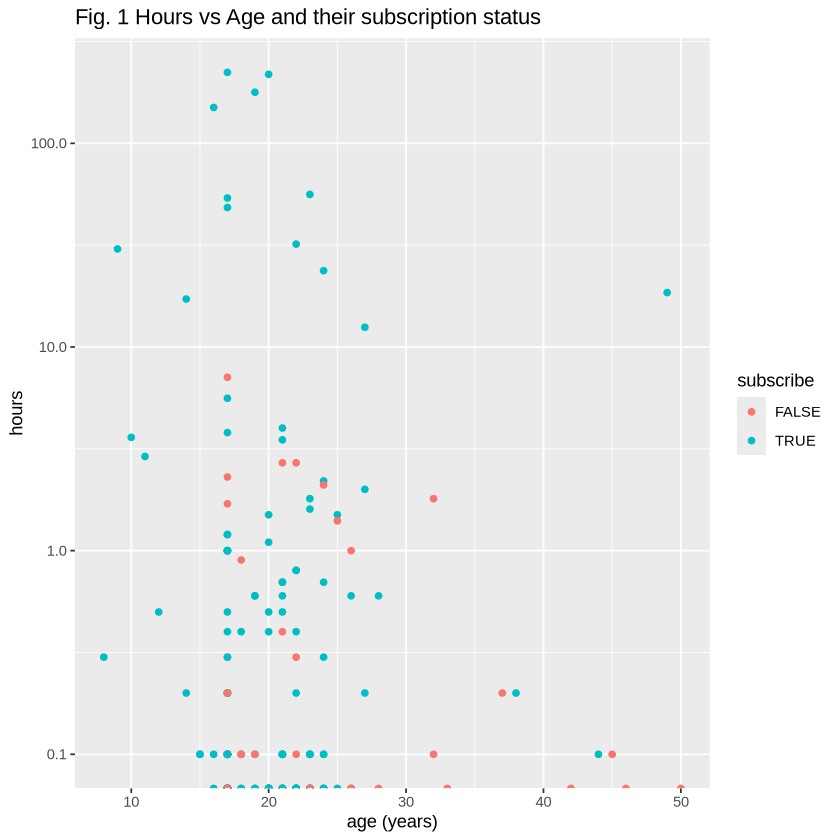

In [85]:
exp_plot <- data |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point()+
    labs(x = "age (years)" , y = "hours", color = "subscribe", title = "Fig. 1 Hours vs Age and their subscription status") +
    scale_y_log10()
exp_plot

Now, to actually attempt to answer the research question at hand, it will be approached as any other KNN classification problem we've ever seen. From Fig 1., it is clear that there is no distinct or easily recognizable linear relationship between the variables and not much of a pattern involving "subscribe". Knowing this, KNN becomes a good way to approach this question as it does well in working with data that does not have a linear pattern. Additionally, this question is a clear classification problem as it works to categorize the participants into one of two groups, those who have subscribed and those who haven't based on their hours played and age.

To start off, the seed should be set in order to make this data reproducible. Secondly, to split the data, prop and strata should be included to ensure a reasonably sized training and testing set and that each set includes some number of subscribed participants. Prop is set to 0.7 to create a 70/30 split for the training and testing data. This lets the training set have a enough amount of data to learn patterns and gives us a sufficient amount of unseen data to later test. Next, in the recipe, it should be noted that the predictors should be scaled as KNN uses distance calculations and we want each factor to contribute equally to these distance calculations. Two functions that will help standardize these values are step_scale() and step_center(). Following the recipe, our model has neighbors set to tune() since we don't currently have an idea for what amount of neighbors we should use.

In [90]:
set.seed(9999)

data_split <- initial_split(data, prop = 0.7, strata = subscribe)
data_train <- training(data_split)
data_test <- testing(data_split)

data_recipe <- recipe(subscribe ~ Age + played_hours, data = data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

Now, in order to find suitable K values, we can test a range of different values then test their accuracies. After collecting this data we can then plot it to visually see how each K value performs relative to each other. This will allow us to make a decision on which K value is best based on the highest accuracy.

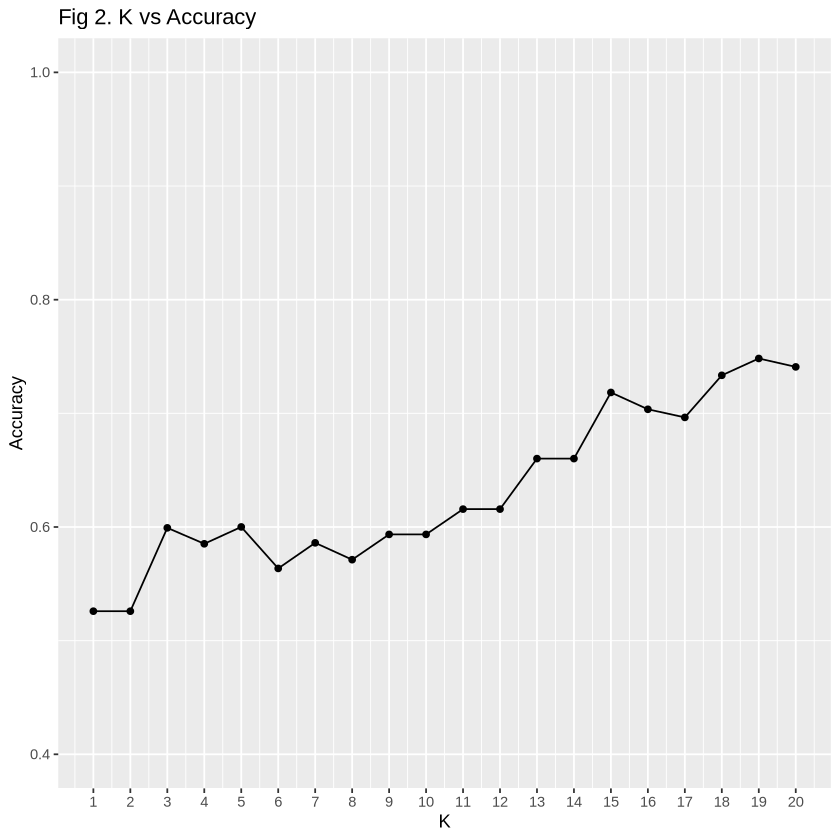

In [91]:
set.seed(9999)

vfold <- vfold_cv(data_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

workflow <- workflow() |>
    add_recipe(data_recipe)|>
    add_model(knn_spec) |>
    tune_grid(resamples = vfold, grid = k_vals)

knn_results <- collect_metrics(workflow)

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()+
    labs(x = "K", y = "Accuracy", title = "Fig 2. K vs Accuracy") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) + 
    scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k


From this plot, K = 19 seems to have the highest accuracy. To test this, a new model can be made where neighbors is now specified to 19. With a new model, a new workflow is needed which can then be passed through predict() with the testing data to see how well K = 19 performs.

In [95]:
new_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
    set_engine("kknn") |>
    set_mode("classification")

new_workflow <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(new_spec) |>
    fit(data_train)

predict <- predict(new_workflow, data_test) |>
    bind_cols(data_test) |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
predict

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136


After running the model with our testing data, it can be concluded that using K = 19, the model's accuracy is 72%.

**DISCUSSION:**

With an accuracy of 72%, it is reasonable to say that this model is dependable and that age and hours spent playing have some predictive power in determining whether or not someone is subscribed to a game related newsletter. Now though it is reasonable, it is still important to note that there is room for error and looking back on Fig 1., it is also reasonable to say that though these factors have some predictive power, they are not the best at predicting "subscribe". Keeping this in mind, the model created in this model can still be useful, it has decent accuracy and the explanatory variables are relatively easy to collect data for. This model may be used to identify a newsletter's potential target audience and help them develop more strategic methods of advertising their newsletter. For future replications of this project, larger data sets can be used to better help the model learn. To further investigate people and their likelihood of being subscribed to a game related newsletter, more/different explanatory variables can be explored. 